# DATA 620 - Assignment 3 Alt

by: Jeremy OBrien and Mael Illien

Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)), please feel free at this point to load just a small subset of the nodes and edges.

Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.

Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information. Please record a short video (~ 5 minutes), and submit a link to the video in advance of our meet-up.

Our plan for Assignment 3 is as follows:
1. Load a publicly available, open-source graph dataset
2. Downsample the graph for ease of visualization
3. Visualize the graph using Neo4j
4. Calculate diagnostics using NetworkX

In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

For Assignment 3 we sourced a Bitcoin OTC trusted weighted signed network dataset from the [Stanford Network Analysis Project](https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html).

[Bitcoin OTC](https://www.bitcoin-otc.com/) is an over-the-counter marketplace for trading bitcoin which also offers a web-of-trust service.  The dataset captures a who-trusts-whom network of anonymous individuals using the Bitcoing OTC platform.  From the perspective of network topology, individuals comprise nodes, relationships are directed edges, and edge weights are trust ratings provided by one user (source node) of another user (target node) on a scale of -10 (total distrust) through 0 (neutral) to +10 (total trust).

This dataset is credited to:
- S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. [Edge Weight Prediction in Weighted Signed Networks](https://cs.stanford.edu/~srijan/pubs/wsn-icdm16.pdf). IEEE International Conference on Data Mining (ICDM), 2016.
- S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. [REV2: Fraudulent User Prediction in Rating Platforms](https://cs.stanford.edu/~srijan/pubs/rev2-wsdm18.pdf). 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018.

In [ ]:
# Import data using pandas
url = 'https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/soc-sign-bitcoinotc.csv'
ratings = pd.read_csv(url, names=['SOURCE','TARGET','RATING','TIMESTAMP'] )
ratings

#### Load data into a graph using NetworkX

In [ ]:
# Compose a directed graph of Bitcoin OTC users
data = open('soc-sign-bitcoinotc.csv', 'r')
graphtype = nx.DiGraph()
graph = nx.parse_edgelist(data, 
                      delimiter=',', 
                      create_using=graphtype,
                      nodetype=int, 
                      data=(('weight', float),('time', float)))

In [ ]:
# Calculate number of users
len(graph.nodes)

In [ ]:
# Calculate number of ratings
len(graph.edges)

In [6]:
# Expand on this graph as needed

#### Downsample the full graph

Given the large size of the Bitcoin OTC network, we'll downsample the number of nodes to reduce the computational resources needed for this Assignment 3.  We use the following procedure:
1. Quasi-randomly sample n = ??? users from the full network, which will serve as source nodes
2. Map other users rated by this random user sample, tracing the outbound directed edges from these source nodes (target nodes)

In [7]:
# Randomly sample 10 users
unique_users = set(ratings['SOURCE']) # Identify unique users
downsample_n = 10 # Set source node sample 
random.seed(620)
ratings_subset = ratings[ratings['SOURCE'].isin(random.sample(unique_users, downsample_n))]

source_nodes = list(set(ratings_subset['SOURCE']))
target_nodes = list(set(ratings_subset['TARGET']))
all_nodes = source_nodes + target_nodes

# Calculate total nodes in random sample
print(len(source_nodes),len(target_nodes),len(all_nodes))

The downsampling procedure yields a smaller, shallower directed graph of 39 total nodes.  This graph will be more amenable to easy visualization than the full graph.

In [9]:
# Do we need to include this cell in the submission?
# ratings_subset

,SOURCE,TARGET,RATING,TIMESTAMP
1938,524,359,1,1.305165e+09
3232,792,202,1,1.306982e+09
3761,792,7,1,1.307310e+09
5836,1331,882,4,1.310536e+09
8912,1852,1771,1,1.331348e+09
10158,1331,2072,5,1.337048e+09
10162,2053,2073,2,1.337098e+09
10249,2053,57,3,1.337532e+09
10781,2053,1948,1,1.339424e+09
10947,2053,1352,2,1.339965e+09


In [10]:
# Reset the index of sample graph
ratings_subset = ratings_subset.reset_index()

In [11]:
# Do we need to include this cell in the submission?
# ratings_subset

,index,SOURCE,TARGET,RATING,TIMESTAMP
0,1938,524,359,1,1.305165e+09
1,3232,792,202,1,1.306982e+09
2,3761,792,7,1,1.307310e+09
3,5836,1331,882,4,1.310536e+09
4,8912,1852,1771,1,1.331348e+09
5,10158,1331,2072,5,1.337048e+09
6,10162,2053,2073,2,1.337098e+09
7,10249,2053,57,3,1.337532e+09
8,10781,2053,1948,1,1.339424e+09
9,10947,2053,1352,2,1.339965e+09


In [ ]:
# Do we need to include the ensuing cells?

### Sample Cypher Queries:

In [13]:
# Return all the nodes
"MATCH (n) RETURN n"

# Delete everything
"MATCH (n) DETACH DELETE n"

'MATCH (n) DETACH DELETE n'

### Load sample graph into Neo4j

In order to visualize the sample graph, we first load the data into Neo4j using Pandas to output separate nodes and edges CSV files.

In [14]:
# Output nodes from sample graph to CSV
df = pd.DataFrame(all_nodes)
df.columns = ['id']
# df
df.to_csv('nodes.csv')

In [15]:
# Output directed edges and weights (ratings) from sample graph to CSV
df = ratings[ratings['SOURCE'].isin(list(all_nodes))]
df = df[['SOURCE','TARGET','RATING']]
# df
df.to_csv('edges.csv')

In [16]:
# Create nodes in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/nodes.csv" AS csvLine
CREATE (u:User {id: (csvLine.id)})"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/mael-a3/Assignment03/nodes.csv" AS csvLine\nCREATE (u:User {id: (csvLine.id)})'

In [17]:
# Create edges in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/edges.csv" AS csvLine
MATCH (u1:User {id: csvLine.SOURCE})
MATCH (u2:User {id: csvLine.TARGET})
CREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/mael-a3/Assignment03/edges.csv" AS csvLine\nMATCH (u1:User {id: csvLine.SOURCE})\nMATCH (u2:User {id: csvLine.TARGET})\nCREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)'

### Visualize sample graph using Neo4j

In [ ]:
# Should we include code to produce the graph below? 

A Neo4j visualization of the sample graph is below.  It's not possible to say if network characteristics are shared by the full graph or purely a result of our sampling procedure.  From a visual analysis, we do note the following:
- Two relatively dense neighborhoods in the upper right and lower right corners, connected directly (nodes 545 and 4197) and via several intermediaries (nodes 7, 57, 1018, and 2028) 
- To isolated branches on the periphery connected to the network by node 2028
- A single island remote and unconnected to the rest of the network, comprised of nodes 524 and 359

![Neo4j Graph](https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/graph.png)

### Export graph from Neo4j into NetworkX to calculate diagnostic metrics

@Mael, would you mind adding some write-up to this section?  I'm going offline briefly.

In [28]:
from neo4j import GraphDatabase
from neo4jconfig import neo4j_auth
%matplotlib inline

In [29]:
gdb = GraphDatabase.driver(uri=neo4j_auth['uri'],auth=(neo4j_auth['user'],neo4j_auth['password']), encrypted=False)
session = gdb.session()

In [30]:
# Return all nodes
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
for r in records:
    #print(r['n'])
    print(r['n']['id'])

2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
2053
4485
2727
524
4141
1331
1331
4886
4886
4886
4886
792
792
792
1852
4638
4638
4638
4638
7
7
7
7
7
7
3977
2067
2067
2067
2067
2067
2067
5013
5013
5013
2072
2072
2073
2073
4635
4635
1948
545
545
545
545
545
4515
4515
4515
4515
4515
4400
4400
4402
4402
4402
1331
1331
1846
1846
1719
57
57
57
57
57
61
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
202
202
202
202
202
2642
2642
2642
2642
2642
2642
2647
2647
4197
4197
4197
4197
4197
4197
4197
4197
4197
359
1383
1383
1383
1771
1771
2028
2028
2028
2028
2028
2028
2028
2028
2028
882
882
882
882
1018
1018
1018
1018
1018
1018
1018
3452
3452
3452


In [31]:
# Return all relationships
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
for r in records:
    rel = r['r']
    if rel is not None:
        #print(rel)
        print(rel.start_node['id'], rel.end_node['id'], rel['rating'])

2053 57 3
2053 3977 1
2053 1948 1
2053 1331 -5
2053 61 -10
2053 1719 -10
2053 1383 -10
2053 1352 2
2053 1846 -10
2053 2073 2
2053 545 2
2053 1331 -5
4485 4402 1
2727 2028 2
524 359 1
4141 2647 9
1331 2072 5
1331 882 4
4886 4197 1
4886 5013 1
4886 4635 1
4886 3452 1
792 7 1
792 202 1
792 2642 5
1852 1771 1
4638 1018 1
4638 2067 1
4638 4515 3
4638 4400 1
7 792 1
7 2028 3
7 545 1
7 57 4
7 882 4
7 202 4
3977 2053 1
2067 2642 7
2067 2028 -1
2067 3452 -10
2067 4515 2
2067 4197 1
2067 4638 1
5013 4886 1
5013 4515 1
5013 4197 1
2072 1331 2
2072 1331 2
2073 1352 1
2073 2053 2
4635 4886 1
4635 4197 2
1948 2053 1
545 1352 3
545 1331 -5
545 1331 -5
545 1719 -1
545 1948 -5
4515 4638 2
4515 5013 1
4515 4197 3
4515 3452 1
4515 2067 1
4400 4638 1
4400 4402 3
4402 4485 1
4402 4400 3
4402 2642 4
1331 882 4
1331 2072 5
1846 1383 -1
1846 1948 2
57 2053 1
57 2028 -10
57 1018 8
57 4197 2
57 7 8
1352 1018 1
1352 1948 -1
1352 1383 -1
1352 1846 -10
1352 2053 2
1352 545 5
1352 1331 -1
1352 1719 -10
1352 61 -1
1

In [32]:
result = session.run("MATCH (u1:User {id: '2296'})-[r:TRUSTS]->(u2) RETURN u1, u2, r.rating AS rating")
for r in result:
    print(r)
    #print(r['u1'], r['u2'].id, r['rating'])
    #print(r['u1'].id, r['u2'].id, r['rating'])
    
#ratings = [(record["rating"] for record in result]
#ratings

In [33]:
# Return all nodes
result = session.run("MATCH (u:User) RETURN u.id AS id")
labels = [] # Used in graphing
node_ids = [record["id"] for record in result]
node_ids = np.array(node_ids).astype(np.int)

In [34]:
def rec2graph(rs):
    graph = nx.MultiDiGraph()
    
    for n_id in node_ids:
        #print(type(n_id))
        nx_properties = {}
        graph.add_node(n_id, **nx_properties)
        labels.append(n_id)
    
    for record in rs:
        rel = record['r']
        #print(rel)
        if rel is not None:
                graph.add_edge(rel.start_node['id'], rel.end_node['id'], weight=rel['rating'])
            
    return graph

In [35]:
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
g = rec2graph(records)
print(nx.info(g))

Name: 
Type: MultiDiGraph
Number of nodes: 76
Number of edges: 138
Average in degree:   1.8158
Average out degree:   1.8158


In [26]:
plt.rcParams['figure.figsize'] = [20, 10]

TypeError: cannot perform reduce with flexible type

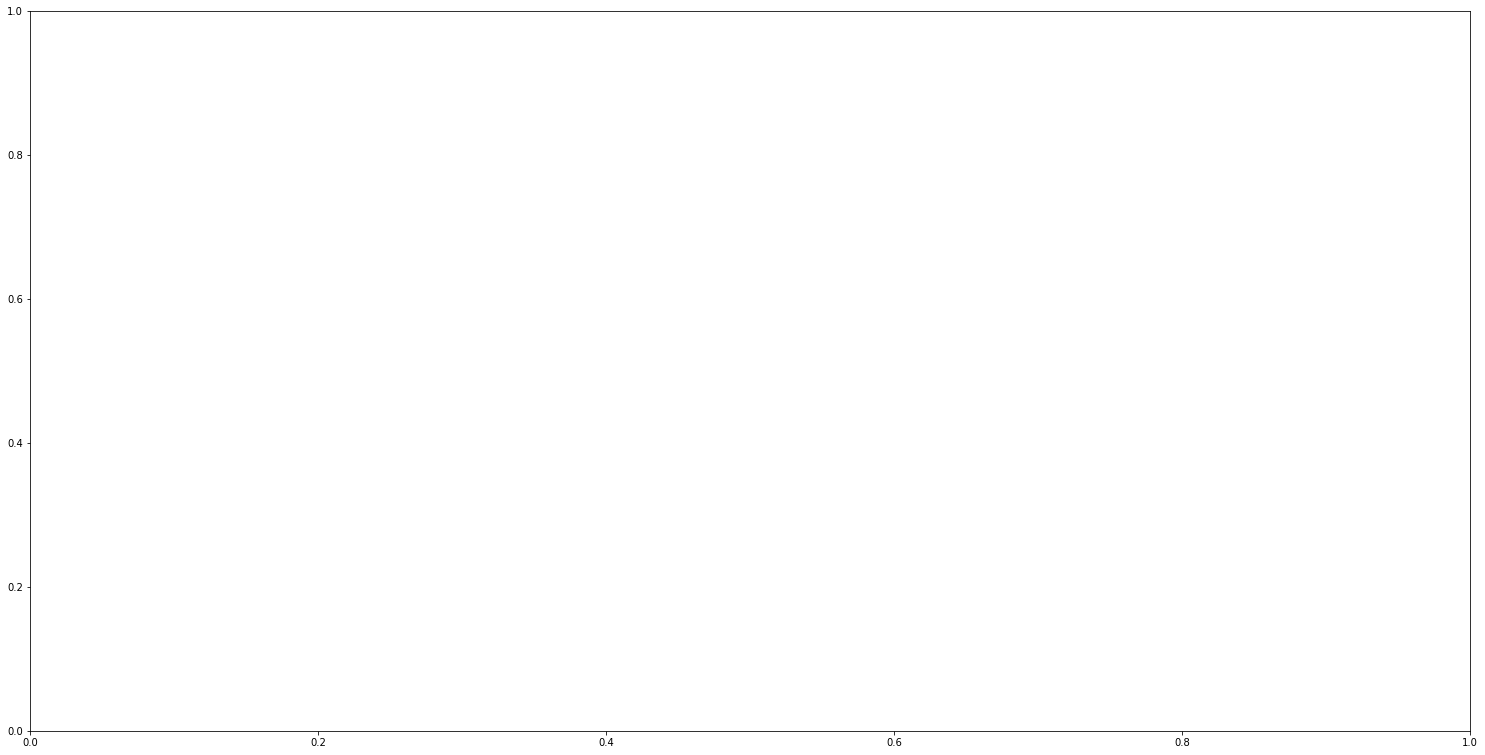

In [27]:
# Simple graph
nx.draw(g, with_labels=True)

In [ ]:
graph_pos = nx.spring_layout(g)
labels = dict(zip(node_ids,labels))

In [ ]:
fig = nx.draw_networkx_nodes(g, graph_pos, alpha=.5, node_color='blue')
fig = nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='blue')
fig = nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')

In [ ]:
df = pd.DataFrame(index=ids)
pagerank = nx.pagerank(g, alpha=.9)
df['pagerank'] = [pagerank[n] for n in ids]

betweenness = nx.betweenness_centrality(g)
df['betweenness'] = [betweenness[n] for n in ids]

In [ ]:
nx.diameter(g)